<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Gridsearching & Hyperparameters

_Authors: Kiefer Katovich (SF), David Yerrington (SF), Matt Brems_

---

![](https://snag.gy/aYcCt2.jpg)

### Learning Objectives
- Describe what the terms gridsearch and hyperparameter mean.
- Build a gridsearching procedure from scratch.
- Apply sklearn's `GridSearchCV` object.
- Use and evaluate attributes of the gridsearch object.
- Describe the pitfalls of searching large hyperparameter spaces.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
# Read in data.
data = pd.read_csv('../datasets/UNdata.csv')

In [3]:
# Examine first five rows.
data.head()

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
0,Afghanistan,Asia,45.0,46.0,154,2848
1,Albania,Europe,68.0,74.0,32,863
2,Algeria,Africa,67.5,70.3,44,1531
3,Angola,Africa,44.9,48.1,124,355
4,Argentina,America,69.6,76.8,22,8055


## United Nations Data

- `country`: the name of the nation
- `region`: the region of the world (Africa, America, Asia, Europe, Oceania)
- `lifeMale`: the life expectancy of males
- `lifeFemale`: the life expectancy of females
- `infantMortality`: the infant mortality rate (generally reported per 1,000 live births)
- `GDPperCapita`: the Gross Domestic Product per person

In [4]:
# Examine distribution of region.
data['region'].value_counts()

Africa     53
Asia       46
Europe     40
America    35
Oceania    14
Name: region, dtype: int64

In [5]:
# How many rows do we have?
data.shape

(188, 6)

In [6]:
# Check for missing values.
data.isnull().sum()

country            0
region             0
lifeMale           0
lifeFemale         0
infantMortality    0
GDPperCapita       0
dtype: int64

In [7]:
# Set country to be the index.
data.set_index('country', inplace = True)

In [8]:
data.head()

,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
country,,,,,
Afghanistan,Asia,45.0,46.0,154,2848
Albania,Europe,68.0,74.0,32,863
Algeria,Africa,67.5,70.3,44,1531
Angola,Africa,44.9,48.1,124,355
Argentina,America,69.6,76.8,22,8055


In [9]:
# Dummy region.
data = pd.get_dummies(data, columns=['region'], drop_first=True)

<details><summary>What is our reference category for this dummy variable?</summary>

- Africa!
- There is no dummy variable for Africa in our data, meaning that all dummy variables would be interpreted **relative to Africa**.
</details>

### Create $Y$ variable

In [10]:
# Create a column with 1 if the female life expectancy is greater
# than the male life expectancy.
data['females_are_strong_as_hell'] = (data['lifeFemale'] > data['lifeMale']).astype(int)

# The column name is a reference to the 
# Netflix series "The Unbreakable Kimmy Schmidt."

In [11]:
# What should we check next?
data['females_are_strong_as_hell'].value_counts(normalize=True)

1    0.989362
0    0.010638
Name: females_are_strong_as_hell, dtype: float64

<details><summary>Do you have any concerns about the above?</summary>
    
- Our classes are severely unbalanced.
- We should check out our tools for handling unbalanced classes. (e.g. moving our classification threshold, implement stratified k-fold cross validation)
- Given the relatively low sample size and the small number of the observations in the minority category here, it is unlikely that our model would be able to predict that a nation has a higher male life expectancy.
</details>

In [12]:
# Create a column with 1 if the female life expectancy is 5
# or more years longer than the male life expectancy.
data['females_are_strong_as_hell'] = (data['lifeFemale'] >= (data['lifeMale'] + 5)).astype(int)

# Check the thing we need to check!
data['females_are_strong_as_hell'].value_counts(normalize=True)

0    0.569149
1    0.430851
Name: females_are_strong_as_hell, dtype: float64

**We are interested in predicting whether or not the female life expectancy of a nation is at least five years great than the male life expectancy.** This is a classification problem.

### Create the training and testing data

In [13]:
# Set up X and y.
X = data.drop(columns='females_are_strong_as_hell')
y = data['females_are_strong_as_hell']

In [14]:
X.head()

,lifeMale,lifeFemale,infantMortality,GDPperCapita,region_America,region_Asia,region_Europe,region_Oceania
country,,,,,,,,
Afghanistan,45.0,46.0,154,2848,0,1,0,0
Albania,68.0,74.0,32,863,0,0,1,0
Algeria,67.5,70.3,44,1531,0,0,0,0
Angola,44.9,48.1,124,355,0,0,0,0
Argentina,69.6,76.8,22,8055,1,0,0,0


In [15]:
# Split our data into training and testing sets.
# I've picked to have a test size of 33% because I want to 
# make sure that I have enough data in the test set to
# meaningfully evaluate my model.

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42,
                                                    stratify = y) # Note the stratify parameter here!

In [16]:
# What did stratify = y do?

print(y_train.value_counts(normalize=True))

print(y_test.value_counts(normalize=True))

0    0.568
1    0.432
Name: females_are_strong_as_hell, dtype: float64
0    0.571429
1    0.428571
Name: females_are_strong_as_hell, dtype: float64


<details><summary>Before we fit a k-Nearest Neighbors model, what do we need to do? Why?</summary>
    
- Standardize our data!
- If we *don't* standardize our data, then features that have larger spreads (e.g. higher ranges or higher standard deviations) will have a disproportionate influence on our model.
- If all of your variables are already on the same scale, then scaling is not necessary.
</details>

In [17]:
# Instantiate.
ss = StandardScaler()

# Fit.
X_train = ss.fit_transform(X_train)

# Fit.
X_test = ss.transform(X_test)

/Users/mattbrems/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mattbrems/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/mattbrems/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## Fit the Default KNN

Below we fit a default `KNeighborsClassifier` to predict `y`. ([Here is the documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))

<details><summary>What is the default number of neighbors used in kNN?</summary>
    
- 5.
</details>

In [18]:
# Instantiate.
knn = KNeighborsClassifier(n_neighbors=5)

# Fit.
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [19]:
# Evaluate.
knn.score(X_test, y_test)

0.7619047619047619

<details><summary>What score is this?</summary>

- Accuracy.
</details>

In [20]:
# Evaluate against the baseline.
y_test.value_counts(normalize=True)

0    0.571429
1    0.428571
Name: females_are_strong_as_hell, dtype: float64

<details><summary>Is selecting k = 5 a good choice? Is it the best choice?</summary>

- We don't know!
- $k$ is a hyperparameter.
</details>

## What are "hyperparameters?"

Models often have built-in quantities that we can use to fine-tune our results. 
- What value of $k$ do we select?
- What distance metric do we select?
- Do we use LASSO or Ridge regularization?
- What value of $\alpha$ or $C$ do we use?

These are quantities our model **cannot** learn. We must decide on these ourselves!

> Alternatively, **parameters** are quantities that a model can learn, like the coefficients of a logistic regression model.

However, different values for hyperparameters can result in substantially different models. 
- Let's [visualize fits for different values of $k$](http://scott.fortmann-roe.com/docs/BiasVariance.html) in $k$-nearest neighbors.

<details><summary>We want to find the optimal values for our hyperparameters. How do you think we might do this?</summary>

- Try as many different values of hyperparameters as possible and see which ones perform the best on our data.
</details>

## Searching for the Best Hyperparameters

Our default KNN performs quite poorly on the test data. But what if we changed the number of neighbors? The weighting? The distance metric?

These are all hyperparameters of the KNN. How would we do this manually? We would need to evaluate on the training data the set of hyperparameters that perform best, and then use this set of hyperparameters to fit the final model and score on the testing set.

### Search code for KNN

In [21]:
# Let's try 3-NN, 5-NN, 10-NN.
neighbors_to_test = [3, 5, 10]

# Let's try uniform and distance weightings.
weightings_to_test = ['uniform', 'distance']

# Let's try Manhattan and Euclidean distances.
distance_metrics_to_test = [1, 2] # Remember that p = 1 is Manhattan, p = 2 is Euclidean

# Instantiate a dictionary to hold our accuracy scores.
accuracies = {}

# Loop through number of neighbors.
for k in neighbors_to_test:
    
    # Loop through the weightings.
    for w in weightings_to_test:
        
        # Loop through our distance metrics.
        for d in distance_metrics_to_test:
            
            # Fit a KNN model with that set of hyperparameters.
            knn = KNeighborsClassifier(n_neighbors=k, weights=w, p=d)
            
            # Generate a set of accuracy scores based on 5-fold cross-validation.
            cv_accuracies = cross_val_score(knn, X_train, y_train, cv=5)
            
            # Average the five accuracy scores and store them in the dictionary.
            accuracies[(k, w, d)] = np.mean(cv_accuracies)

In the pseudocode above, we would find the key in the dictionary (a hyperparameter set) that has the largest value (mean cross-validated accuracy).

<details><summary>Which model should I fit?</summary>
    
- a 5-nearest neighbors model using distance weighting and the Manhattan distance.
</details>

In [22]:
accuracies

{(3, 'uniform', 1): 0.8075641025641026,
 (3, 'uniform', 2): 0.8383076923076922,
 (3, 'distance', 1): 0.8152307692307692,
 (3, 'distance', 2): 0.8379743589743589,
 (5, 'uniform', 1): 0.7912564102564101,
 (5, 'uniform', 2): 0.7903076923076922,
 (5, 'distance', 1): 0.8392820512820511,
 (5, 'distance', 2): 0.8146410256410256,
 (10, 'uniform', 1): 0.7265384615384616,
 (10, 'uniform', 2): 0.7185384615384616,
 (10, 'distance', 1): 0.8066153846153845,
 (10, 'distance', 2): 0.7982820512820512}

![](./images/grid.jpg)

**One method of searching for the optimal set of hyperparameters is called gridsearching.**

Gridsearching gets its name from the fact that we are searching over a "grid" of parameters. For example, imagine the `n_neighbors` hyperparameters on the x-axis and `distances` on the y-axis, and we need to check the accuracy for all combinations of hyperparameters on the grid.

**Gridsearching uses cross-validation internally to evaluate the performance of each set of hyperparameters.** More on this later.

### Using `GridSearchCV`

This would be an annoying process to have to do manually. Luckily sklearn comes with a convenience class for performing gridsearch:

```python
from sklearn.model_selection import GridSearchCV
```

The `GridSearchCV` has a handful of important arguments:

| Argument | Description |
| --- | ---|
| **`estimator`** | The sklearn instance of the model to fit on |
| **`param_grid`** | A dictionary where keys are hyperparameters for the model and values are lists of values to test |
| **`cv`** | The number of internal cross-validation folds to run for each set of hyperparameters |
| **`n_jobs`** | How many cores to use on your computer to run the folds (-1 means use all cores) |
| **`verbose`** | How much output to display (0 is none, 1 is limited, 2 is printouts for every internal fit) |


Below is an example for how one might set up the gridsearch for our KNN:

```python
knn_parameters = {
    'n_neighbors':[3,5,10],
    'weights':['uniform','distance'],
    'p':[1,2]
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_gridsearcher.fit(X_train, y_train)
```

**Try out the sklearn gridsearch below on the training data.** [You can find the GridSearchCV documentation here.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
# Create dictionary of hyperparameters.
# The keys MUST match the names of the arguments!
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}

In [25]:
# Instantiate our GridSearchCV object.
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), # What is the model we want to fit?
                              knn_params, # What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1)

In [26]:
# Fit the GridSearchCV object to the data
knn_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
/Users/mattbrems/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Examining the Results of the Grid Search

Once the grid search has fit (this can take awhile!) we can pull out a variety of information and useful objects from the gridsearch object, stored as attributes:

| Property | Use |
| --- | ---|
| **`results.param_grid`** | Displays parameters searched over. |
| **`results.best_score_`** | Best mean cross-validated score achieved. |
| **`results.best_estimator_`** | Reference to model with best score.  Is usable / callable. |
| **`results.best_params_`** | The parameters that have been found to perform with the best score. |
| **`results.grid_scores_`** | Display score attributes with corresponding parameters. | 

In [27]:
# Print out the best score found in the search.

knn_gridsearch.best_score_

0.856

In [28]:
# Print out the set of hyperparameters that achieved the best score.
knn_gridsearch.best_params_

{'metric': 'manhattan', 'n_neighbors': 1}

**We can store the best fit model (`best_estimator_`) to a variable, then score it on the test data!**

In [29]:
# Store the best fit model as best_knn.
best_knn = knn_gridsearch.best_estimator_

# Evaluate the best fit model on the test data.
best_knn.score(X_test, y_test)

0.746031746031746

**Let's see.... _EVERYTHING!_**

In [30]:
pd.DataFrame(knn_gridsearch.cv_results_).head()

/Users/mattbrems/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mattbrems/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mattbrems/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/mattbrems/an

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000878,0.000140,0.001478,0.000557,euclidean,1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.846154,0.88,0.88,...,0.848,0.030206,2,1.000000,1.00,1.00,1.00,1.000000,1.000000,0.000000
1,0.000551,0.000017,0.000777,0.000046,euclidean,11,"{'metric': 'euclidean', 'n_neighbors': 11}",0.846154,0.76,0.76,...,0.744,0.071464,8,0.818182,0.81,0.80,0.81,0.831683,0.813973,0.010566
2,0.000552,0.000014,0.000784,0.000002,euclidean,21,"{'metric': 'euclidean', 'n_neighbors': 21}",0.846154,0.92,0.76,...,0.800,0.073506,4,0.787879,0.77,0.81,0.82,0.801980,0.797972,0.017494
3,0.000560,0.000019,0.000912,0.000128,euclidean,31,"{'metric': 'euclidean', 'n_neighbors': 31}",0.923077,0.96,0.68,...,0.816,0.110400,3,0.737374,0.78,0.85,0.81,0.821782,0.799831,0.038461
4,0.000567,0.000026,0.000897,0.000072,euclidean,41,"{'metric': 'euclidean', 'n_neighbors': 41}",0.884615,0.92,0.64,...,0.784,0.110121,5,0.747475,0.75,0.79,0.79,0.792079,0.773911,0.020584


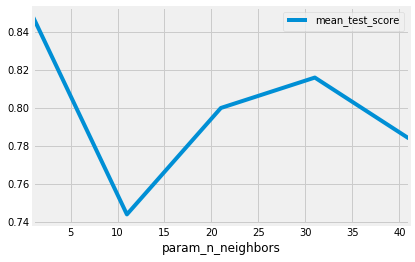

In [31]:
gs_df = pd.DataFrame(knn_gridsearch.cv_results_)
gs_df = gs_df[gs_df['param_metric'] == 'euclidean']
gs_df.plot(x='param_n_neighbors', y='mean_test_score')

## A Word of Caution on Grid Searching

`sklearn` models often have many options/hyperparameters with many different possible values. It may be tempting to search over a wide variety of them. In general, this is not wise.

<details><summary>Why not?</summary>

- Remember that GridSearch searches over **all possible combinations of hyperparameters in the parameter dictionary!**

Imagine that we had this as our parameter dictionary:

```python
parameter_grid = {
    'n_neighbors': range(1, 151),
    'weights': ['uniform', 'distance', custom_function],
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'leaf_size': range(1, 152),
    'metric': ['minkowski', 'euclidean'],
    'p': [1, 2]
}
```

**How many different combinations will need to be tested?**

| Parameter | Number of Chosen Values |
| --- | --- |
| **n_neighbors** | 150 |
| **weights** | 3 |
| **algorithm** | 4 |
| **leaf_size** | 151 |
| **metric** | 2 |
| **p** | 2 |
| <br>_150 \* 3 \* 4 \* 151 \* 2 \* 2 = n combinations_ <br><br>| _1,087,200_ |

If we select `cv = 5`, we would fit 1,087,200 models on five folds, meaning we fit 5,436,000 models!

If you're not careful, GridSearching can quickly blow up.

> **It is extremely important to understand what the hyperparameters do and think critically about what ranges are useful and relevant to your model!**
</details>

## An aside: estimators and transformers.
`sklearn` has two types of classes: **estimators** and **transformers**. 

We've seen several examples of each so far.

### Scikit-Learn Estimators
Estimators are essentially _models_. They fit this format:

```python
# Instantiate.
model = MyCoolModel(params)
# Fit.
model.fit(X_train, y_train)
# Predict.
y_pred = model.predict(X_test)
```

Estimators have a **fit** and **predict** method.

### Scikit-Learn Transformers
Transformers are not models. They transform your data using similar syntax to estimators. They work like this:

```python
# Instantiate.
trf = MyCoolTransformer(params)
# Fit.
trf.fit(X_train)
# Transform.
X_transformed = trf.transform(X_train)
```

Instead of `fit` and `predict`, they have **fit** and **transform** methods. In fact, since you fit and transform together so often, they have a shortcut:

```python
trf = MyCoolTransformer(params)
X_transformed = trf.fit_transform(X_train)
```

We've seen a few transformers `StandardScaler()` and `PolynomialFeatures()`. There's also `OneHotEncoder()` for dummy encoding and `LabelEncoder()` for factorizing variables. Later we'll see `PCA()`, which is also a transformer.

### Why is this relevant?

Check out the [StandardScaler documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Transformers may have hyperparameters as well - **but we can't GridSearch over a transformer**! There's no way for me to get an accuracy (or other) score from just a transformer, since a transformer can't predict!

![](./images/grid.jpg)

In addition, the acronym ETL, meaning "extract, transform, load," is a very common one in data science. When we gather data from one or more places, there might be **a lot** of preprocessing going on.

Oftentimes, we'll want to apply several transformers to a dataset, *then* build a model. 
- If you do all of these preprocessing steps independently, your code can be messy and it'll be prone to errors!
- It can be challenging to consistently recreate this process.

## Pipelines
![](./images/pipe.png)

Pipelines will allow us to do two things:
1. Chain many transformers together before ending in an estimator.
2. Allow us to GridSearch over a transformer's hyperparameters.

In [32]:
# Import Pipeline
from sklearn.pipeline import Pipeline

In [33]:
# Build a StandardScaler + kNN pipeline.
pipe = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [34]:
# Fit.
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [35]:
# Evaluate.
pipe.score(X_test, y_test)

0.7619047619047619

In [36]:
# Get params - yes, you can GridSearchCV over these!
# Notice the naming convention of pipe arguments.
pipe.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=None, n_neighbors=5, p=2,
              weights='uniform'))],
 'sc': StandardScaler(copy=True, with_mean=True, with_std=True),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=None, n_neighbors=5, p=2,
            weights='uniform'),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [37]:
# Instantiate pipeline object.
pipe_2 = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [38]:
# Define dictionary of parameters.
pipe_2_params = {'sc__with_mean': [True, False], 
                 'sc__with_std': [True, False],
                 'knn__p': [1, 2], 
                 'knn__weights': ['uniform', 'distance'],
                 'knn__n_neighbors': [3, 5, 10]}

In [39]:
# Instantiate our GridSearchCV object.
pipe_2_gridsearch = GridSearchCV(pipe_2, # What is the model we want to fit?
                                 pipe_2_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1)

In [40]:
# Fit the GridSearchCV object to the data.
pipe_2_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.0s finished
/Users/mattbrems/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
# Print out best score.
pipe_2_gridsearch.best_score_

0.84

In [42]:
# Print out best estimator.
pipe_2_gridsearch.best_estimator_

Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'))])

In [43]:
# Save best estimator as pipe_2_final.

pipe_2_final = pipe_2_gridsearch.best_estimator_

In [44]:
# Evaluate the best model on the test data.

pipe_2_final.score(X_test, y_test)

0.7301587301587301

<details><summary>What would you conclude from this output?</summary>
    
- Our model is overfit to the data.
- GridSearching gets us the best performing model on the training set; we always have to take care to not overfit!
</details>

## (BONUS) RandomizedSearchCV + Visualizing Results

When you're exploring a particularly high number of different parameters, it can be advantageous to do a randomized search instead of a GridSearch.

`from sklearn.model_selection import RandomizedSearchCV`

A good blog post on GridSearch, RandomizedSearch, and visualizing the outputs of these methods [can be found here](https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9).